In [1]:
## A surface kinetics demo to help me get my bearings

In [146]:
import rmgpy.chemkin
import os

import matplotlib.pyplot as plt
import copy

# import rmgpy.constants

import numpy as np
import scipy.optimize
# import re

# import yaml
%matplotlib inline

In [137]:
# load an example catalysis mechanism from RMG

cur_dir = '/home/moon/rmg/rmg2kmc/surface_kinetics_demo/'
gas_mech_file = os.path.join(cur_dir, 'chem_annotated-gas.inp')
surface_mech_file = os.path.join(cur_dir, 'chem_annotated-surface.inp')
transport = os.path.join(cur_dir, 'tran.dat')
dictionary_path = os.path.join(cur_dir, 'species_dictionary.txt')

gas_species, gas_reactions = rmgpy.chemkin.load_chemkin_file(
    gas_mech_file,
    dictionary_path=dictionary_path,
)
surface_species, surface_reactions = rmgpy.chemkin.load_chemkin_file(
    surface_mech_file,
    dictionary_path=dictionary_path,
)


# need to copy the species thermo into the reactions because for some reason it's not already there

all_sp = gas_species + surface_species
for i in range(len(surface_reactions)):
    for j in range(len(surface_reactions[i].reactants)):
        for ref_sp in all_sp:
            if ref_sp.is_isomorphic(surface_reactions[i].reactants[j]):
                surface_reactions[i].reactants[j] = ref_sp
                break
        else:
            print('no match found')
    for j in range(len(surface_reactions[i].products)):
        for ref_sp in all_sp:
            if ref_sp.is_isomorphic(surface_reactions[i].products[j]):
                surface_reactions[i].products[j] = ref_sp
                break
        else:
            print('no match found')


# get the site density from the file
with open(surface_mech_file, 'r') as f:
    for line in f:
        if 'SDEN' in line and ('mol/cm2' in line or 'mol/cm^2' in line):
            site_density = float(line.split('/')[1]) * 100.0 * 100.0  # convert to mol/m2
            break
    else:
        site_density = 2.72E-5  # default value
        raise ValueError('Could not find site density in surface mechanism file')

In [122]:
reaction_index = 4

In [123]:
def plot_kinetics(rxns, labels=None, SDEN=2.5e-5):
    """Function for plotting reaction kinetics
    Takes in a list of RMG reactions (rmgpy.reaction.Reaction) or a single reaction
    """
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('ln(k)')

    if type(rxns) != list:
        rxns = [rxns]
    

    T = np.linspace(300, 3000, 1001)
    for rxn in rxns:
        k = np.zeros(len(T))
        for i in range(0, len(T)):
            if hasattr(rxn, 'kinetics') and type(rxn.kinetics) == rmgpy.kinetics.surface.StickingCoefficient:
                k[i] = rxn.get_rate_coefficient(T[i], 101325, surface_site_density=SDEN)
            else:
                k[i] = rxn.get_rate_coefficient(T[i], 101325)
        plt.plot(1000.0 / T, np.log(k))

    if labels:
        plt.legend(labels)
    plt.show()


## Here's a barrierless sticking reaction that has a temperature exponent

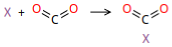

StickingCoefficient(A=0.195, n=0.25, Ea=(0,'kcal/mol'), T0=(1,'K'))


In [124]:
display(surface_reactions[4])
print(surface_reactions[4].kinetics)

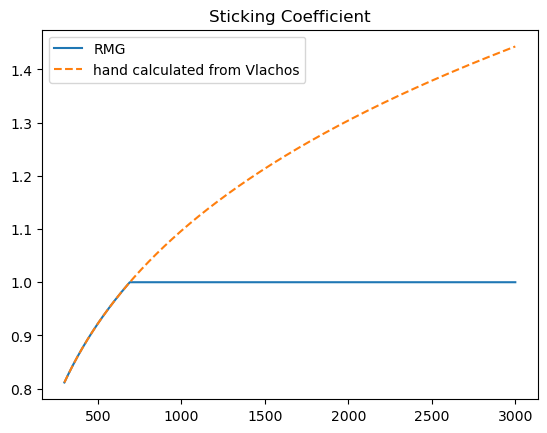

In [80]:
## Plot just the sticking coefficient
T = np.linspace(300, 3000, 1001)

s = np.zeros(len(T))
for i in range(0, len(T)):
    s[i] = surface_reactions[reaction_index].kinetics.get_sticking_coefficient(T[i])
    
s2 = 0.195 * np.float_power(T, 0.25)
plt.plot(T, s, label='RMG')
plt.plot(T, s2, linestyle='dashed', label='hand calculated from Vlachos')
plt.title('Sticking Coefficient')
plt.legend()

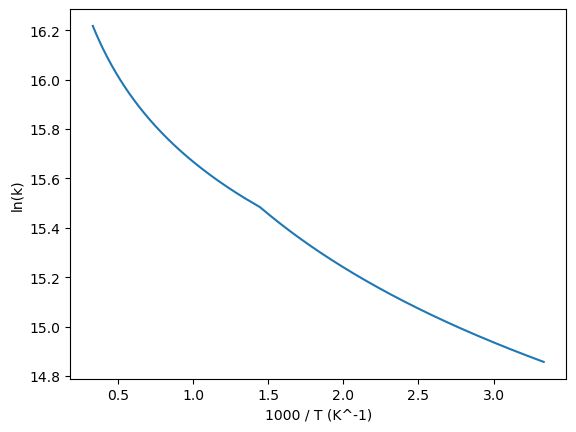

In [81]:
# plot the kinetics
plot_kinetics(surface_reactions[reaction_index], SDEN=site_density)


In [181]:
# what if we force it into simple Arrhenius kinetics such that the rate matches up exactly
# at our temperature of interest?

Ts = np.linspace(300, 3000, 1001)
lnks = np.zeros(len(Ts))

for i in range(0, len(Ts)):
    lnks[i] = np.log(surface_reactions[reaction_index].get_rate_coefficient(Ts[i], 101325, surface_site_density=site_density))

R = 8.314  # J/mol/K
xs = 1.0 / Ts

In [182]:
def my_function(x, m):
    return m * x

In [183]:
T0 = 1000
y0 = np.log(surface_reactions[reaction_index].get_rate_coefficient(T0, 101325, surface_site_density=site_density))
x0 = 1.0 / T0

ydata = lnks - y0
xdata = xs - x0

popt, pconv = scipy.optimize.curve_fit(my_function, xdata, ydata)

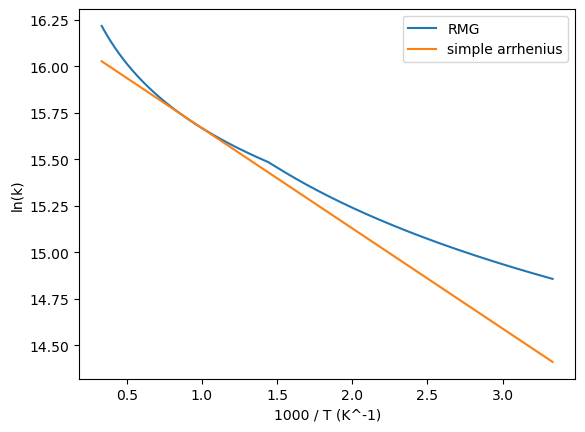

In [184]:
m = popt[0]
b = y0 - m * x0
A = np.exp(b)
Ea = -m * R

# my_fwd_reaction = rmgpy.kinetics.arrhenius.Arrhenius()
my_fwd_kinetics = rmgpy.kinetics.surface.SurfaceArrhenius()
my_fwd_kinetics.Ea = (Ea, 'J/mol')
my_fwd_kinetics.A = (A, 'm^3/(mol*s)')


plot_kinetics([surface_reactions[reaction_index], my_fwd_kinetics], labels=['RMG', 'simple arrhenius'], SDEN=site_density)

In [185]:
my_fwd_reaction = copy.deepcopy(surface_reactions[reaction_index])
my_fwd_reaction.kinetics = my_fwd_kinetics

## Now show me the reverse rates

In [186]:
rmg_rev = surface_reactions[reaction_index].generate_reverse_rate_coefficient(surface_site_density=site_density)
simple_rev = my_fwd_reaction.generate_reverse_rate_coefficient(surface_site_density=site_density)

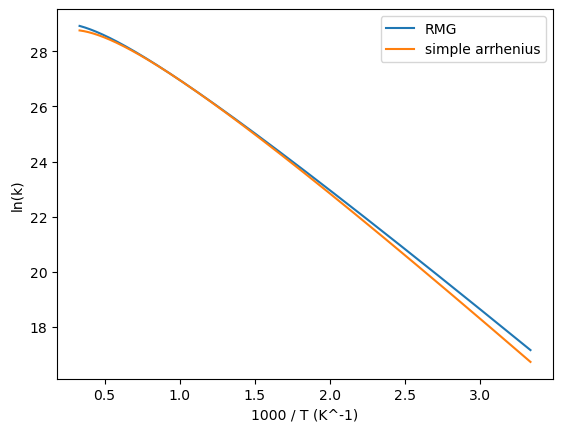

In [187]:
plot_kinetics([rmg_rev, simple_rev], labels=['RMG', 'simple arrhenius'], SDEN=site_density)

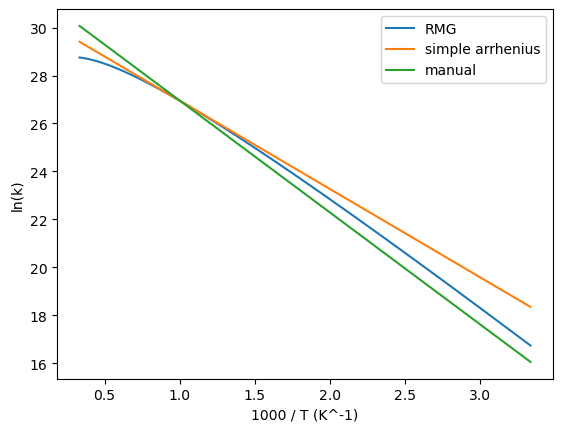

In [212]:
# The "simple" reverse isn't quite so simple and still has a temperature exponent;
# we can force it into an even simpler form:

Ts_2 = np.linspace(300, 3000, 1001)
lnks_2 = np.zeros(len(Ts_2))

for i in range(0, len(Ts_2)):
    lnks_2[i] = np.log(simple_rev.get_rate_coefficient(Ts_2[i], 101325))

R = 8.314  # J/mol/K
xs_2 = 1.0 / Ts


T0_2 = 1000
y0_2 = np.log(simple_rev.get_rate_coefficient(T0_2, 101325))
x0_2 = 1.0 / T0_2

ydata_2 = lnks_2 - y0_2
xdata_2 = xs_2 - x0_2

popt_2, pconv_2 = scipy.optimize.curve_fit(my_function, xdata_2, ydata_2)

m_2 = popt_2[0]
b_2 = y0_2 - m_2 * x0_2
A_2 = np.exp(b_2)
Ea_2 = -m_2 * R


my_rev_kinetics = rmgpy.kinetics.surface.SurfaceArrhenius()
my_rev_kinetics.Ea = (Ea_2, 'J/mol')
my_rev_kinetics.A = (A_2, 'm^3/(mol*s)')



# manually construct the reverse kinetics:
Ea_manual = my_fwd_kinetics.Ea.value_si - my_fwd_reaction.get_enthalpy_of_reaction(T0)

kfwd = my_fwd_kinetics.get_rate_coefficient(T0_2)
K = my_fwd_reaction.get_equilibrium_constant(T0_2)
krev = kfwd / K
A_manual = krev / np.exp(-Ea_manual / R / T0_2)

my_manual_rev_kinetics = rmgpy.kinetics.surface.SurfaceArrhenius()
my_manual_rev_kinetics.A = (A_manual, 'm^3/(mol*s)')
my_manual_rev_kinetics.Ea = (Ea_manual, 'J/mol')



plot_kinetics([simple_rev, my_rev_kinetics, my_manual_rev_kinetics], labels=['RMG', 'simple arrhenius', 'manual'], SDEN=site_density)

In [208]:
my_fwd_kinetics.Ea.value_si

4479.365479012197

In [215]:
print(simple_rev.get_rate_coefficient(1000))
print(my_rev_kinetics.get_rate_coefficient(1000))
print(my_manual_rev_kinetics.get_rate_coefficient(1000))

506381472294.95465
506487501572.52905
508688669608.5196


In [216]:
(50.6 - 50.8) / 50.6

-0.00395256916996039

In [209]:
my_fwd_kinetics.Ea.value_si - my_fwd_reaction.get_enthalpy_of_reaction(T0)

38856.310475812585

In [197]:
# confirm that the activation energy changes by the enthalpy of reaction
print(f'Forward rate Ea: {my_fwd_kinetics.Ea.value_si}')
print(f'Reverse rate Ea: {my_rev_kinetics.Ea.value_si}')


# print(f'Enthalpy of reaction: {my_fwd_reaction.get_free_energy_of_reaction(T0)}')
print(f'Enthalpy of reaction: {my_fwd_reaction.get_enthalpy_of_reaction(T0)}')
print(f'Enthalpy of reaction: {my_fwd_reaction.get_enthalpy_of_reaction(T0)}')
print(f'Difference: {- my_fwd_kinetics.Ea.value_si - my_rev_kinetics.Ea.value_si}')

Forward rate Ea: 4479.365479012197
Reverse rate Ea: 30662.335283101158
Enthalpy of reaction: -34376.94499680039
Difference: -35141.70076211335


In [205]:
my_fwd_kinetics.Ea.value_si - my_fwd_reaction.get_enthalpy_of_reaction(T0)

38856.310475812585

In [203]:
my_fwd_reaction.get_equilibrium_constant(T=1000)

1.2536087693853317e-05

In [139]:
rmg_rev

SurfaceArrhenius(A=(1.23679e+17,'s^-1'), n=-1.10559, Ea=(39.6269,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2000,'K'), comment="""Fitted to 29 data points; dA = *|/ 1.11066, dn = +|- 0.0138952, dEa = +|- 0.0726412 kJ/mol""")

In [129]:
# Keep the same activation barrier and just adjust the A factor
my_fwd_reaction = rmgpy.kinetics.arrhenius.Arrhenius()
my_fwd_reaction.Ea = surface_reactions[reaction_index].kinetics.Ea

T0 = 1000
R = 8.314  # J/mol/K
if surface_reactions[reaction_index].kinetics.Ea.value_si == 0:
    A = surface_reactions[reaction_index].get_rate_coefficient(T0, 101325, surface_site_density=site_density)
else:
    lnA = - np.log(surface_reactions[reaction_index].get_rate_coefficient(T0, 101325, surface_site_density=site_density)) * \
        R * T0 / surface_reactions[reaction_index].kinetics.Ea.value_si

my_fwd_reaction.A = (A, 'm^3/(mol*s)')

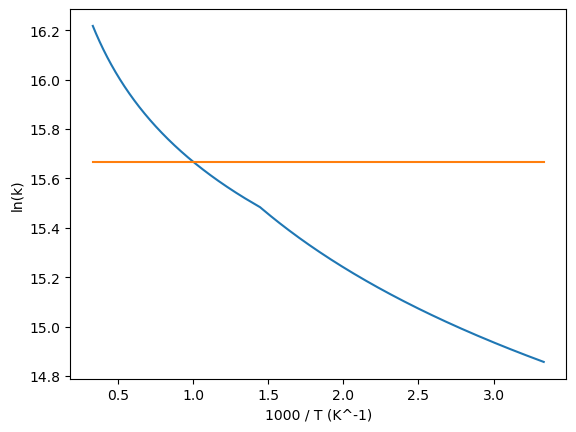

In [130]:
plot_kinetics([surface_reactions[4], my_fwd_reaction], SDEN=site_density)

In [131]:
my_fwd_reaction

Arrhenius(A=(6.37508e+06,'m^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'))

In [132]:
for r in surface_reactions:
    print(r)

X(4) + X(4) + O2(3) <=> O_X(5) + O_X(5)
X(4) + O(6) <=> O_X(5)
X(4) + CO-2(7) <=> CO_X(8)
X(4) + X(4) + CO2(1) <=> O_X(5) + CO_X(8)
X(4) + CO2(1) <=> CO2_X(9)
X(4) + CO2_X(9) <=> O_X(5) + CO_X(8)
X(4) + X(4) + H2(10) <=> H_X(11) + H_X(11)
X(4) + OH_X(12) <=> O_X(5) + H_X(11)
H_X(11) + CO2_X(9) <=> OH_X(12) + CO_X(8)
X(4) + H2O_X(13) <=> H_X(11) + OH_X(12)
O_X(5) + H2O_X(13) <=> OH_X(12) + OH_X(12)
X(4) + OH(14) <=> OH_X(12)
X(4) + H2O(15) <=> H2O_X(13)
X(4) + X(4) + H2O(15) <=> H_X(11) + OH_X(12)
X(4) + H(16) <=> H_X(11)
X(4) + COOH(17) <=> COOH_X(18)
X(4) + COOH_X(18) <=> OH_X(12) + CO_X(8)
X(4) + COOH_X(18) <=> H_X(11) + CO2_X(9)
H2O_X(13) + CO_X(8) <=> H_X(11) + COOH_X(18)
OH_X(12) + CO2_X(9) <=> O_X(5) + COOH_X(18)
H2O_X(13) + CO2_X(9) <=> OH_X(12) + COOH_X(18)
H_X(11) + CO2(1) <=> COOH_X(18)
X(4) + X(4) + HCOO(19) <=> CHO2X2(20)
H_X(11) + CO2_X(9) <=> CHO2X2(20)
X(4) + OH_X(12) + CO2_X(9) <=> O_X(5) + CHO2X2(20)
X(4) + C(21) <=> C_X(22)
X(4) + CO_X(8) <=> O_X(5) + C_X(22)
H_X(11) 